# Advanced Regression - Suprise Housing Assignment

## Table of Contents

1. [Problem Statement](#problem-statement)
2. [Importing Libraries](#importing-all-the-libraries-and-enabling-common-settings)
3. [Common Functions](#common-functions)
4. [Data Understanding](#data-understanding)
    1. [Importing Data](#importing-data)
    2. [Data Info](#data-info)
5. [Data Cleaning](#data-cleaning)
    1. [Remove Empty Rows](#remove-empty-rows)
    2. [Remove Empty Columns](#remove-empty-columns)
    3. [Remove Unwanted Columns](#remove-columns-having-majority-values-as-nulls)
    4. [Data Conversion](#data-conversion)
    5. [Data Imputation](#data-imputation)
6. [Data Exploration](#data-exploration)
7. [Model Building](#model-building)
    1. [Ridge](#ridge-regression)
    2. [Lasso](#lasso)
8. [Model Comparison](#model-comparison)
9. [Inference](#inference)
10. [Subject Questions](#subjective-questions)
    1. [Question 1](#question-1)
    2. [Question 2](#question-2)
    3. [Question 3](#question-3)
    4. [Question 4](#question-4)


## Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
Which variables are significant in predicting the price of a house, and
How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

### Business Goal:
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Importing all the libraries and enabling common settings

In [147]:
import numpy as np # math library
import pandas as pd # to work with datasets
import matplotlib.pyplot as plt # used for plotting simple 2D graphs
import seaborn as sns # visualization library based on matplotlib
import re # library to work on string manipulation
import warnings # library to show warning messages

import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features

from sklearn.model_selection import train_test_split # used for splitting the dataframe into training and testing dataframes
from sklearn.preprocessing import MinMaxScaler # used for scaling the values
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE # recursive feature elimination
from sklearn.linear_model import LinearRegression # Linear regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # Used for VIF
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm # statsmodel
from sklearn.metrics import r2_score, mean_squared_error # Used for R square value
from sklearn.linear_model import Ridge, Lasso


# pandas settings
# pd.options.display.float_format = '{:.6f}'.format # sometimes numbers can show up in scientific format. using this option will show numbers in flot format with 2 decimals
pd.options.display.max_columns = None # remove limitations on number of columns
pd.options.display.max_rows = 100

# we can ignore warnings that arise because of versions
warnings.filterwarnings('ignore')
input_file = 'train.csv'

## Common Functions

In [148]:
def missing_value_percentage(input_df):
    """
    purpose: to create a df that will contain all columns with the percentage of missing values
    input: DataFrame
    output: DataFrame
    """
    missing_count = input_df.isnull().sum()
    percent_missing = missing_count * 100 / len(input_df)
    missing_value_df = pd.DataFrame({'column_name': input_df.columns,
                                     'missing_count': missing_count,
                                 'percent_missing': percent_missing})
    # print(missing_value_df)
    return missing_value_df

def show_metrics(y_train, y_train_pred, y_test, y_pred):
    ''' 
    Takes in the values of true y_train and y_test, and predicted y_train and y_test.
    Prints out 
    1. R-Squared (Train)
    2. R-Squared (Test)
    3. RSS (Train)
    4. RSS (Test)
    5. MSE (Train)
    6. MSE (Test)
    7. RMSE (Train)
    8. RMSE (Test)
    
    Returns a list containing all the above 8 metrics
    
    '''
    
    ## Create a list to save all metrics (will be used in creating a final summary in the end)
    metric = []
    
    ## R-squared of train and test data
    print("R-Squared (Train) =", '%.2f' % r2_score(y_train, y_train_pred))
    metric.append(r2_score(y_train, y_train_pred))
    print("R-Squared (Test) =", '%.2f' % r2_score(y_test, y_pred))
    metric.append(r2_score(y_test, y_pred))
    
    ## Residual sum of squares of train and test data
    rss_train = np.sum(np.square(y_train - y_train_pred))
    metric.append(rss_train)
    rss_test = np.sum(np.square(y_test - y_pred))
    metric.append(rss_test)
    print("RSS (Train) =", '%.2f' % rss_train)
    print("RSS (Test) =", '%.2f' % rss_test)
    
    
    ## Mean Squared Error of train and test data
    mse_train = mean_squared_error(y_train, y_train_pred)
    metric.append(mse_train)
    mse_test = mean_squared_error(y_test, y_pred)
    metric.append(mse_test)
    print("MSE (Train) =", '%.2f' % mse_train)
    print("MSE (Test) =", '%.2f' % mse_test)
    

    
    # Root Mean Squared Error for train and test data
    rmse_train = mse_train**0.5
    metric.append(rmse_train)
    rmse_test = mse_test**0.5
    metric.append(rmse_test)
    print("RMSE (Train) =", '%.2f' % rmse_train) 
    print("RMSE (Test) =", '%.2f' % rmse_test) 
    

    return metric

## Data Understanding

### Importing Data

In [149]:
housing_df = pd.read_csv(input_file) # reading the input loan csv file
housing_df.head() # checking the initial 5 rows

# Observations:
# data seems to have got imported without any errors

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Info

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	
OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
		
YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
CentralAir: Central air conditioning

       N	No
       Y	Yes
		
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		
1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: Kitchens above grade

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		
WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
		
MiscVal: $Value of miscellaneous feature

MoSold: Month Sold (MM)

YrSold: Year Sold (YYYY)

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

In [150]:
print(housing_df.shape) #shows the column and row count
print(housing_df.info(verbose = True,show_counts = True)) # shows not null counts and data type of all columns
print(housing_df.drop_duplicates().shape)
housing_df.describe(include='all') # provided summary statistics of all columns
# Observations:
# Dataset contains 1460 rows and 81 columns 
# Although some of these are integer/float data type columns but they look like categorical columns
# Some columns have missing values
# There are no duplicates in the dataset

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

## Data Cleaning

### Remove empty rows


In [151]:
housing_df = housing_df.dropna(how='all', axis=0) # dropna removes empty rows or cols based on config
print(housing_df.shape) 

# Observations:
# There are no empty rows

(1460, 81)


### Remove empty columns

In [152]:
housing_df = housing_df.dropna(how='all', axis=1) # dropna removes empty rows or cols based on config
print(housing_df.shape) 
housing_df.head()

# Observations:
# No columns are completely empty

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Remove columns having majority values as nulls

In [153]:
# checking columns for missing value percentage
missing_value_df = missing_value_percentage(housing_df)
missing_value_columns = missing_value_df[missing_value_df.percent_missing >= 40]['column_name'].to_list()
print(missing_value_columns)


housing_df = housing_df.drop(columns = missing_value_columns)
print(housing_df.shape) 

# Observations:
# 5 columns 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature' can be removed as more than 40% of their values is null

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
(1460, 76)


### Remove Unnecessary columns

In [154]:
# Checking summary statistics again 
housing_df.describe(include='all') # provide summary statistics of all columns
# Observations:
# 1. Id column can be removed after doing seperate value_counts analysis

housing_df = housing_df.drop(columns = ['Id'])


### Data Conversion

In [155]:
## Convert the below columns to object type
housing_df[['MSSubClass', 'OverallQual', 'OverallCond']] = housing_df[['MSSubClass', 'OverallQual', 'OverallCond']].astype('object')
# Checking summary statistics again 
housing_df.describe(include='all') # provide summary statistics of all columns

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.0,1460,1201.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.0,1460.0,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,15.0,5,NaN,NaN,2,4,4,2,5,3,25,9,8,5,8,10.0,9.0,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,6,NaN
top,20.0,RL,NaN,NaN,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5.0,5.0,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,536.0,1151,NaN,NaN,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,397.0,821.0,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1267,1198,NaN
mean,NaN,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,NaN,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,NaN,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,NaN,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954.000000,1967.000000,NaN,NaN,NaN,NaN,NaN,0

### Data Imputation

In [156]:
housing_df.isna().sum()

# Observations:
# 1. Some columns seem to have missing values which are not actually missing as they are coded as NA - 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath     

In [157]:
# Replacing np.nan with None

housing_df[[ 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = housing_df[[ 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].replace(np.nan, "None")

housing_df.isna().sum()



MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath     

In [158]:
# Imputing using mode for each of the below variables

housing_df[[ 'MasVnrType']] = housing_df[[ 'MasVnrType']].replace(np.nan, "None")
housing_df[[ 'MasVnrArea']] = housing_df[[ 'MasVnrArea']].replace(np.nan, 0.0)

housing_df[[ 'Electrical']] = housing_df[[ 'Electrical']].replace(np.nan, "SBrkr")

# Imputing LotFrontage using mean
housing_df['LotFrontage'].fillna(housing_df['LotFrontage'].mean(), inplace=True)

# Imputing GarageYrBlt with values from Yearbuilt as mean/mode might hamper the quality of data
housing_df.GarageYrBlt.fillna(housing_df.YearBuilt, inplace=True)


housing_df.isna().sum()


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

## Data Exploration

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

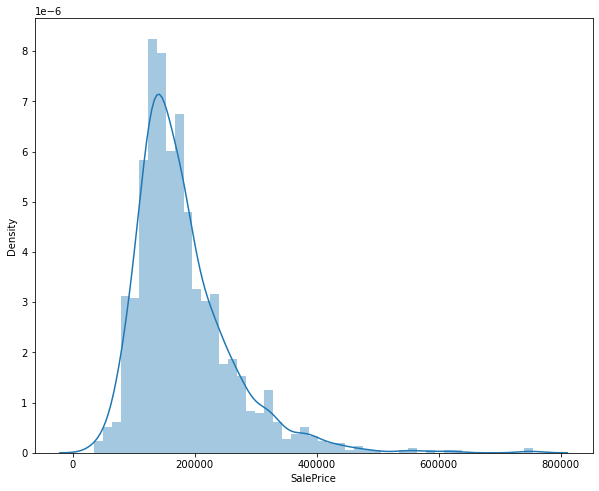

In [159]:
# Analyzing target column

plt.figure(figsize=[10,8])
sns.distplot(housing_df['SalePrice'])

# Observations: Seems like the data is heavily skewed

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

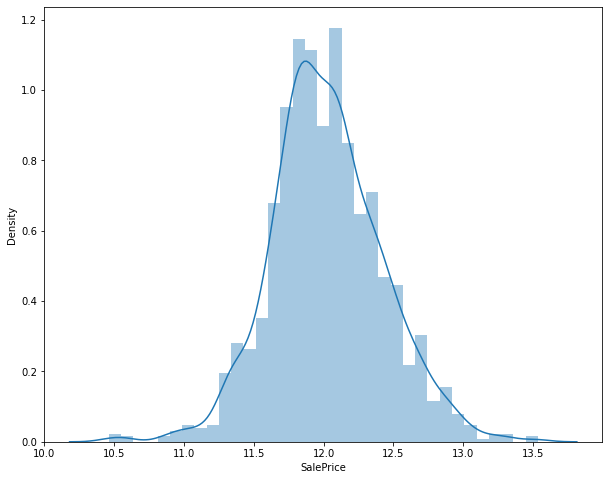

In [160]:
## Log transform the target variable
housing_df['SalePrice'] = np.log(housing_df['SalePrice'])

plt.figure(figsize=[10,8])
sns.distplot(housing_df['SalePrice'])

# Observations - After log transform, data looks normal now

In [161]:
# Extracting Numeric columns
housing_df_num = housing_df.select_dtypes(include=['int64', 'float64'])
housing_df_num.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,12.247694
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,12.109011
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,12.317167
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,11.849398
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,12.429216


In [162]:
# Extracting Categorical columns
housing_df_cat = housing_df.select_dtypes(include=['object'])
housing_df_cat.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


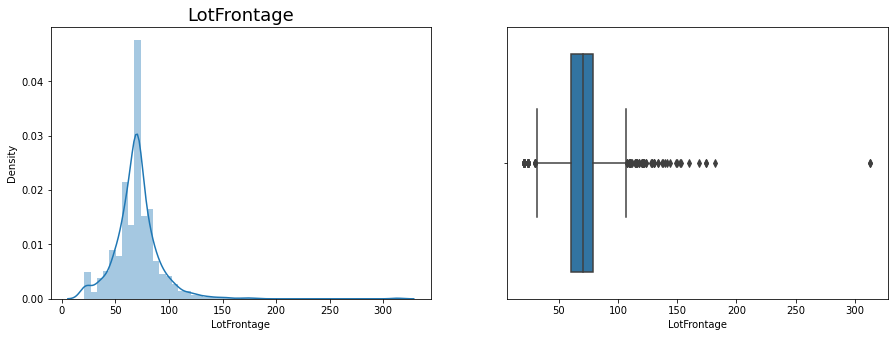

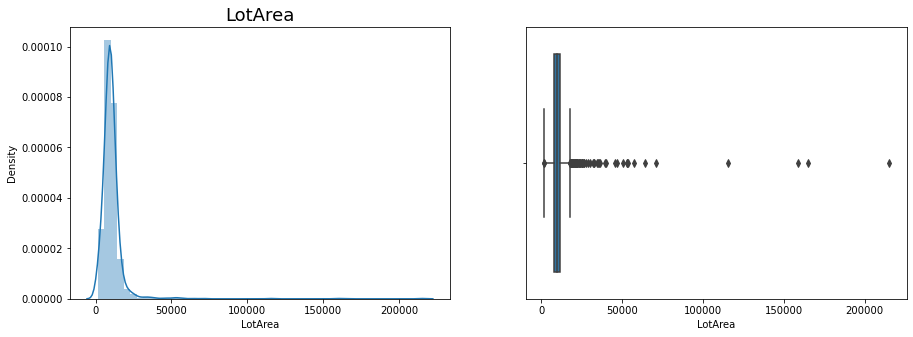

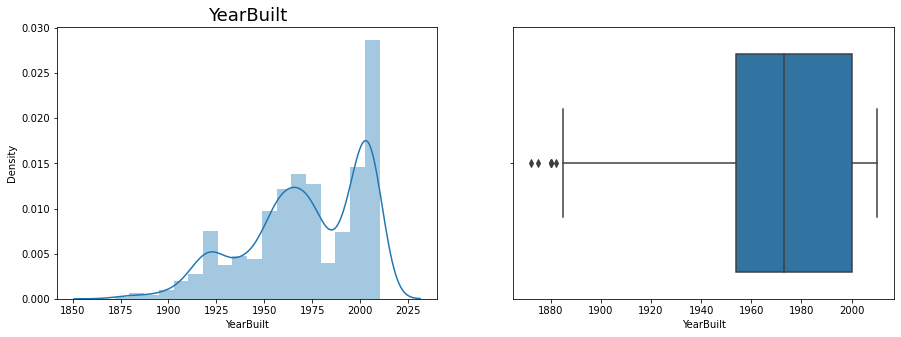

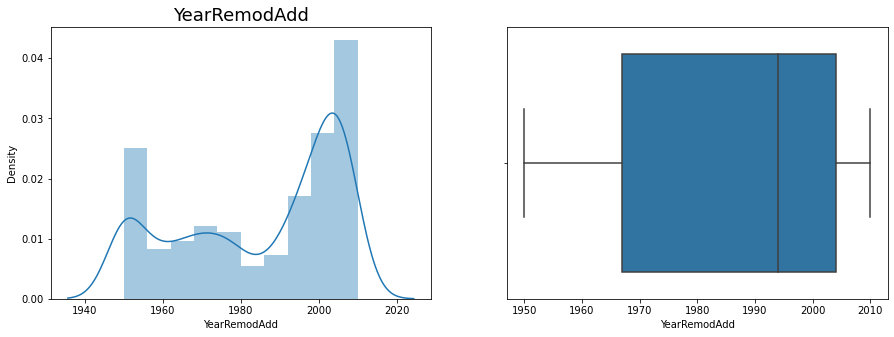

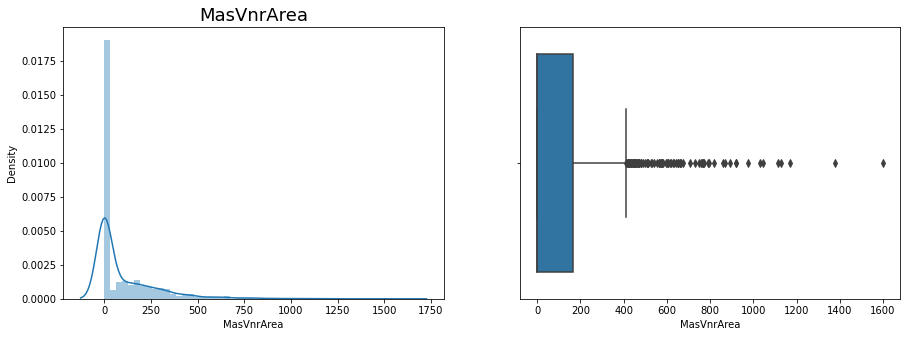

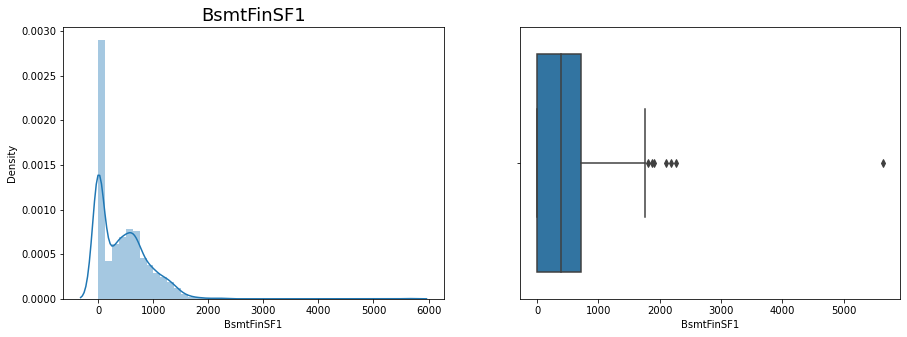

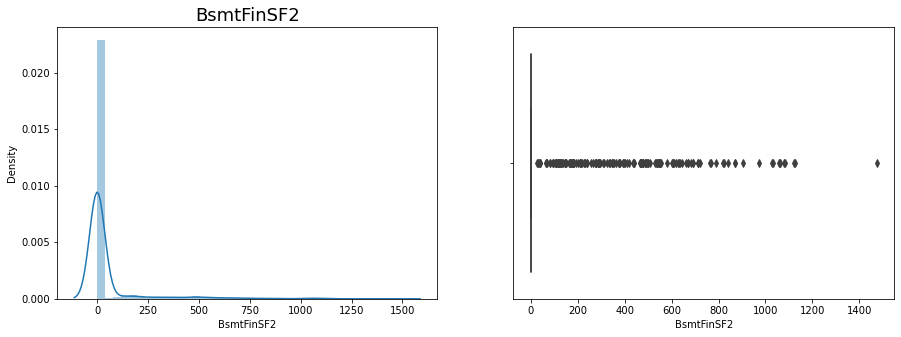

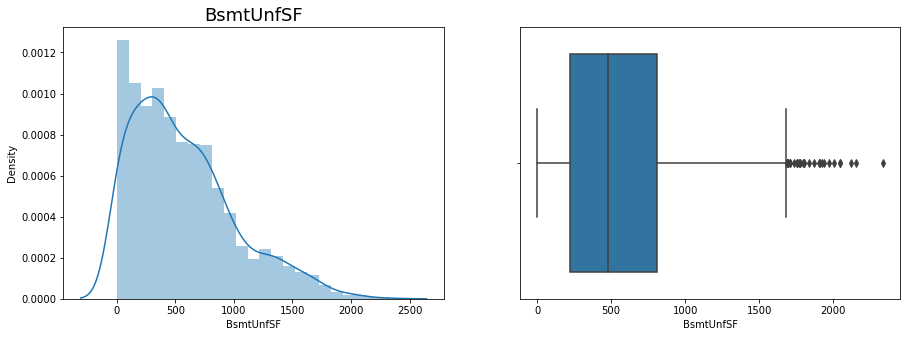

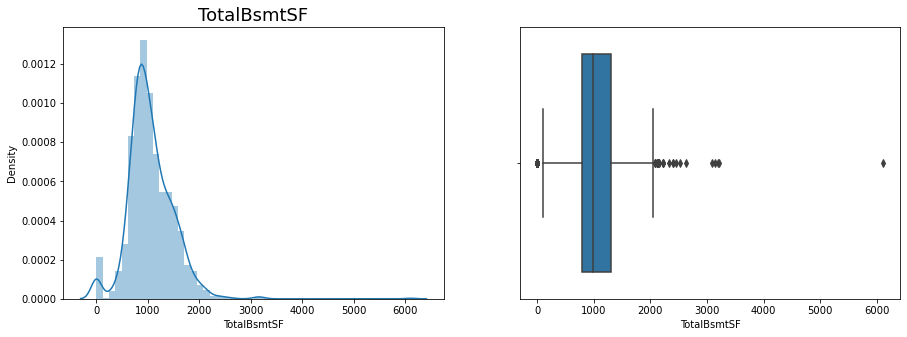

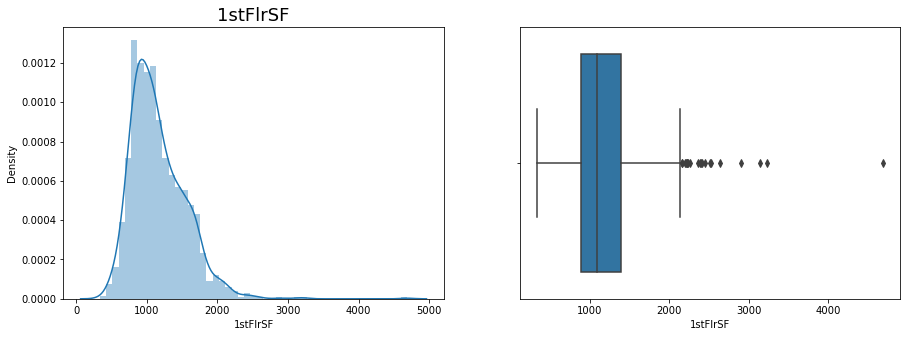

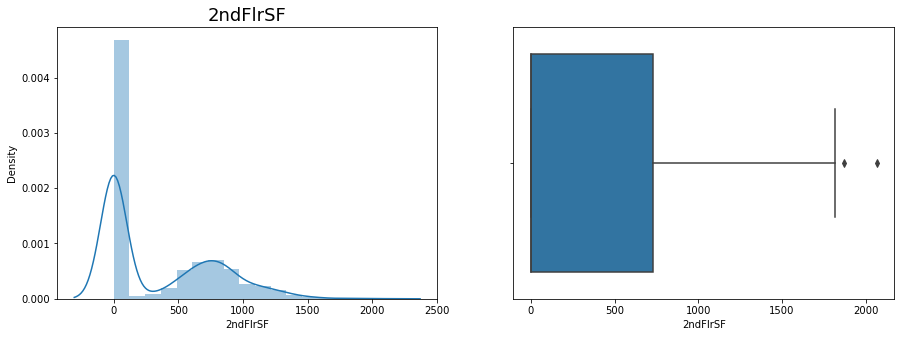

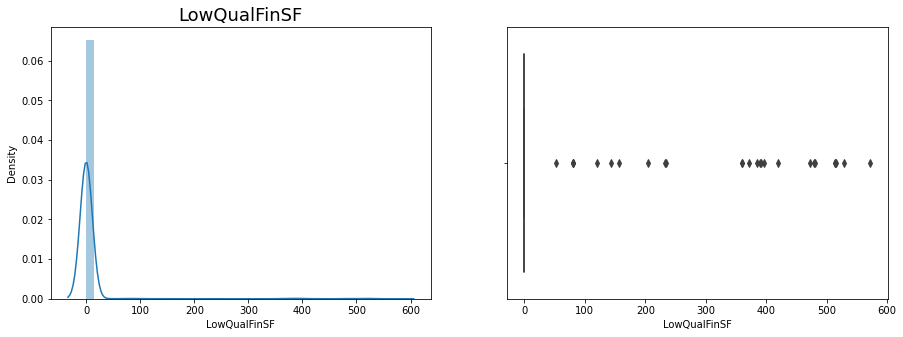

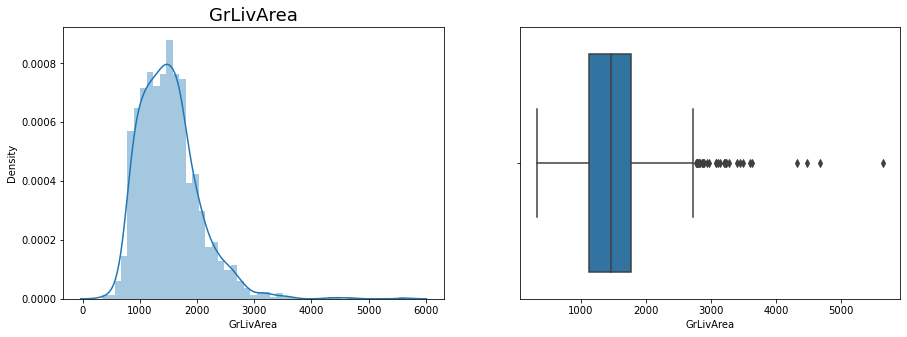

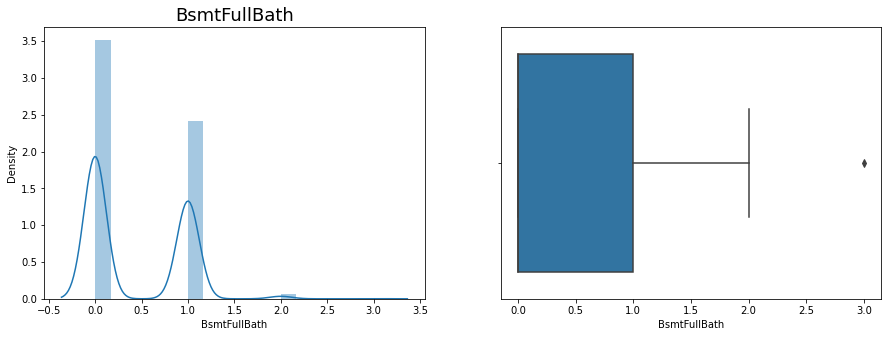

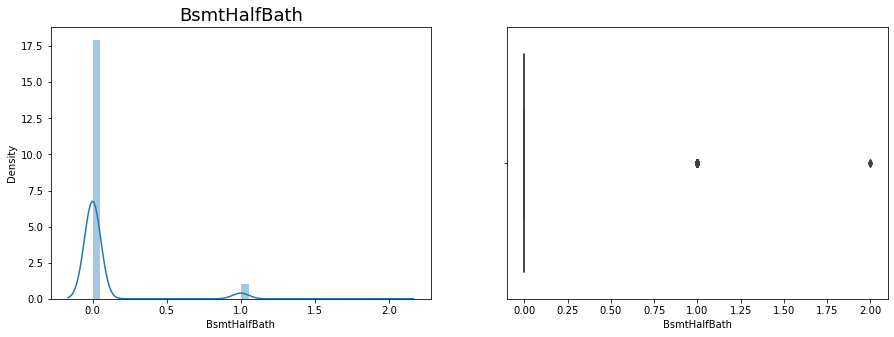

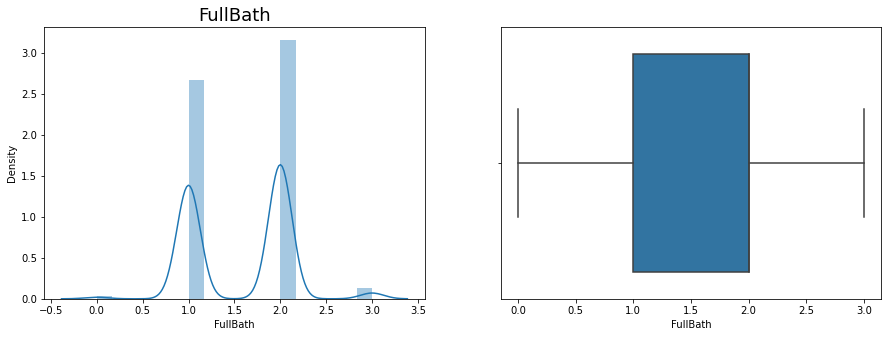

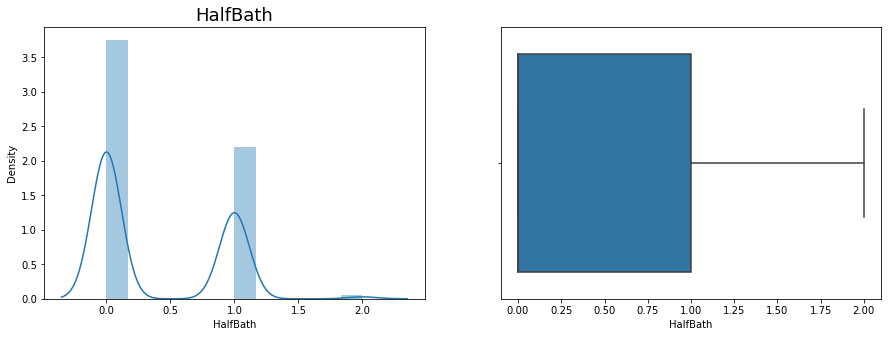

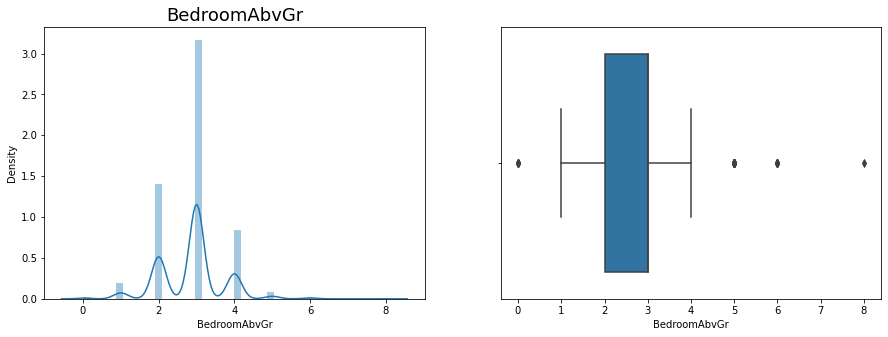

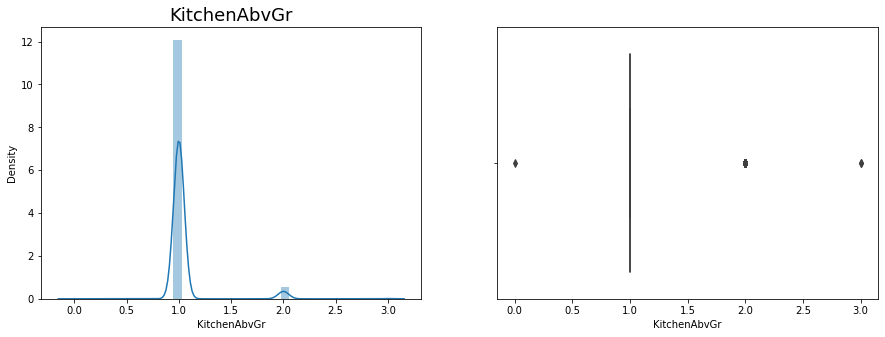

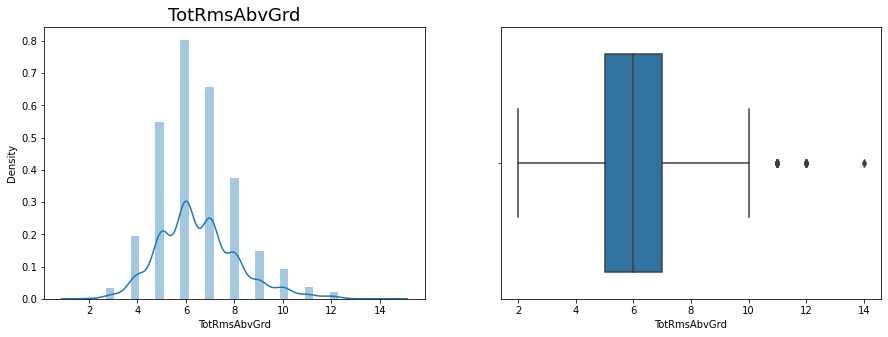

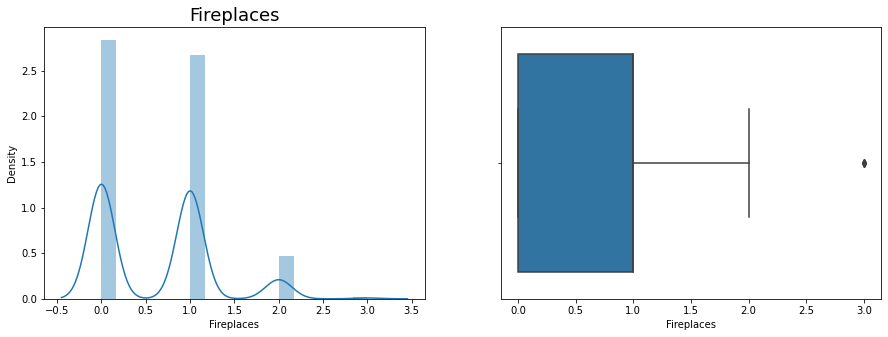

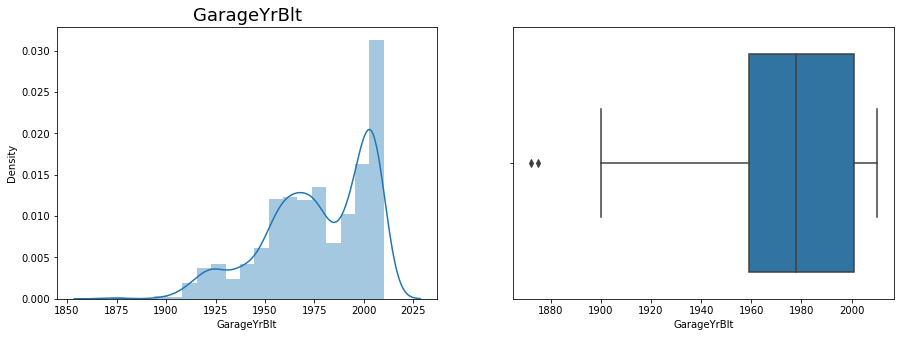

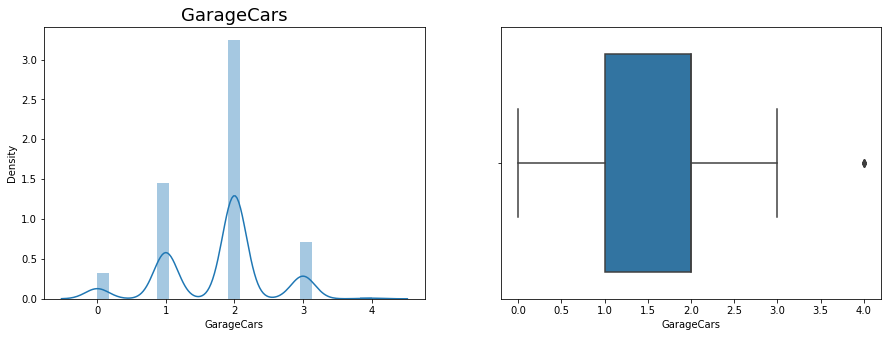

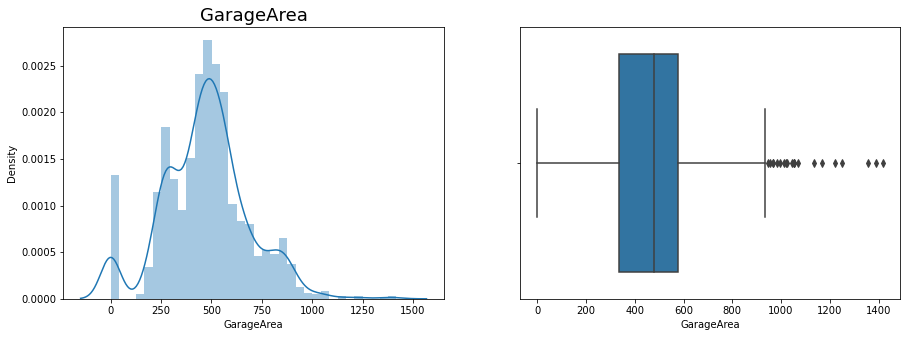

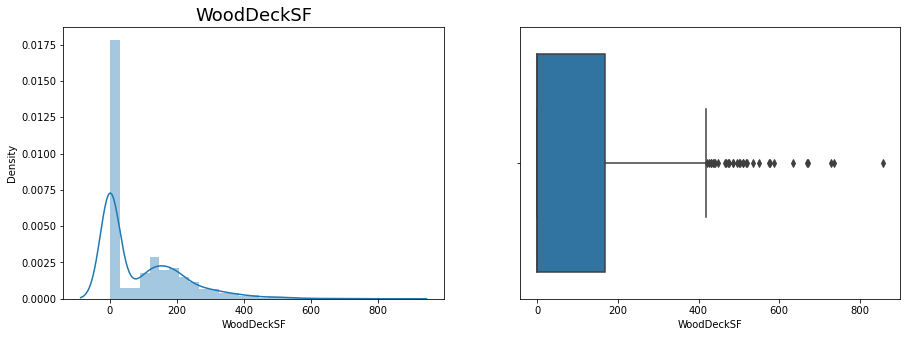

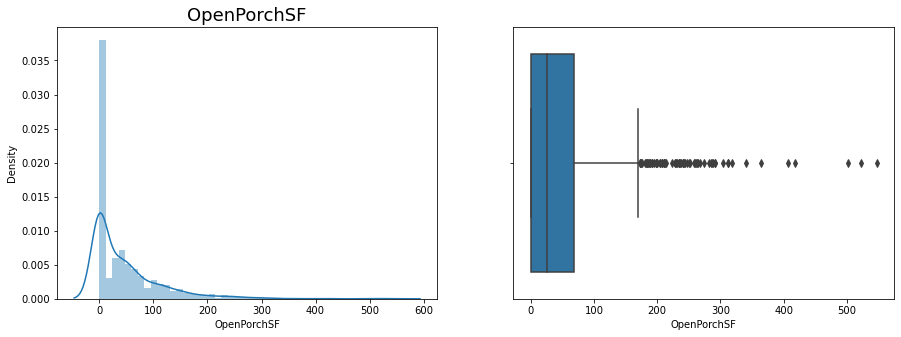

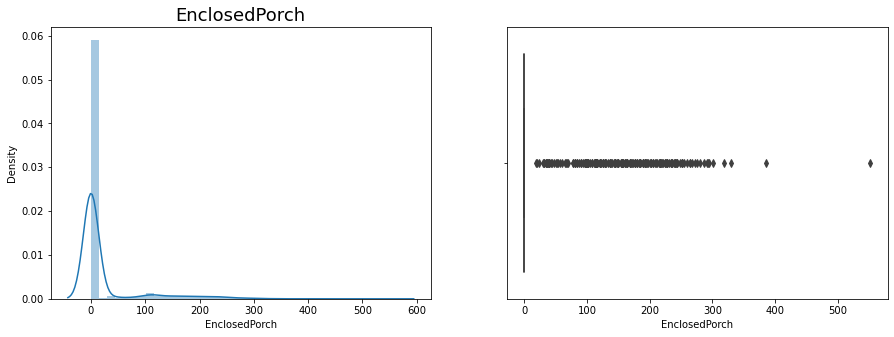

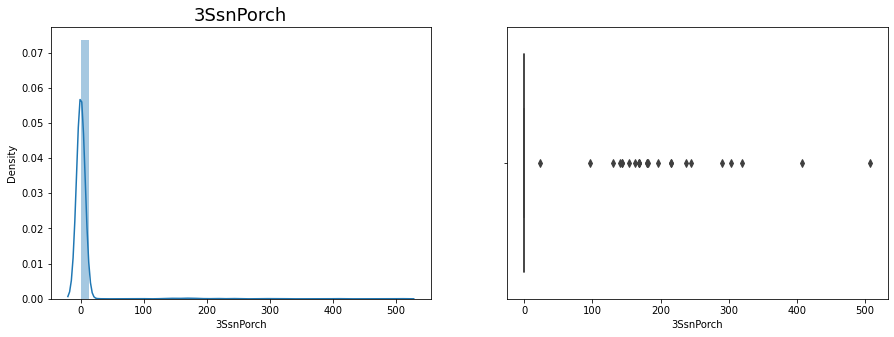

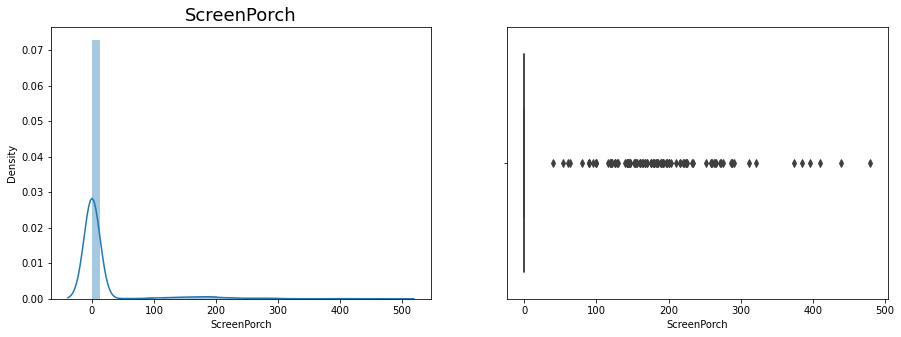

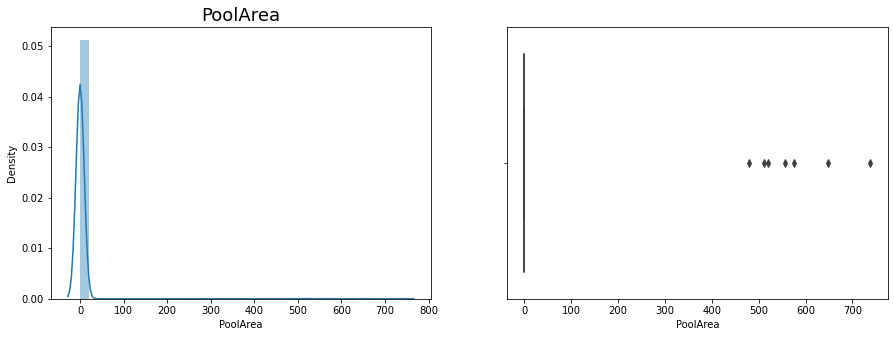

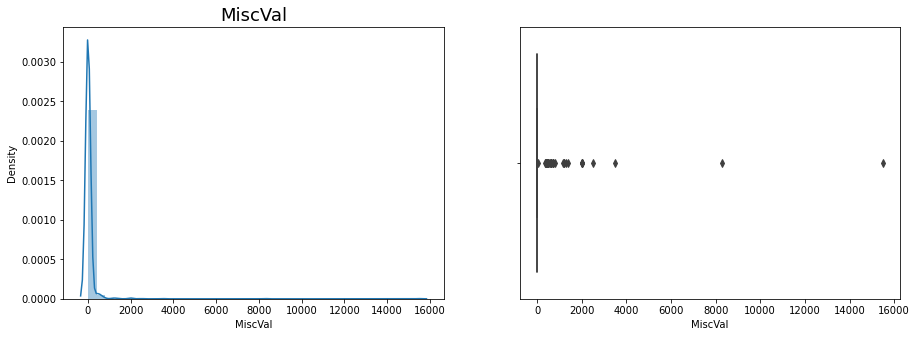

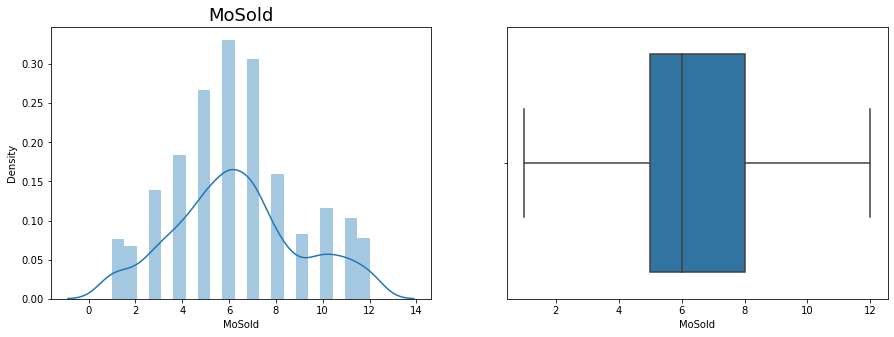

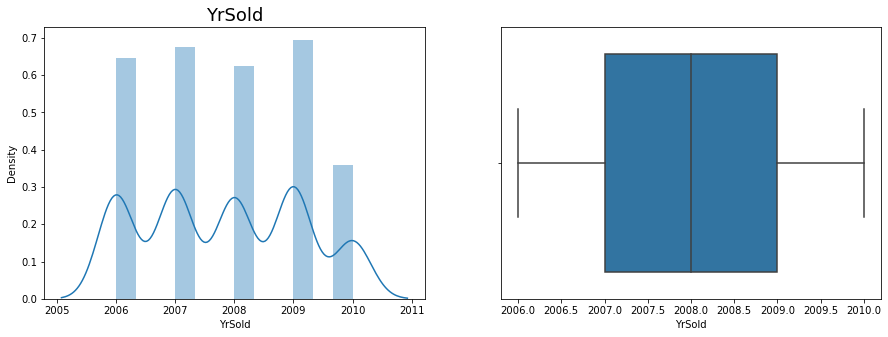

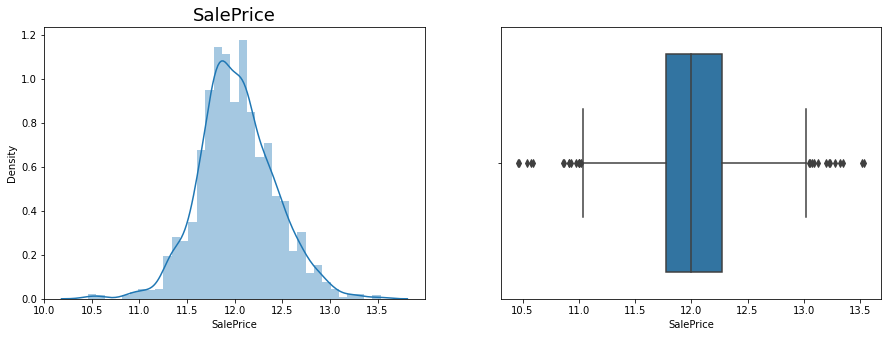

In [163]:
# EDA on numeric columns

## View the distribution of all numeric variables using histograms and boxplots

for col in housing_df_num.columns:
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 18})
    sns.distplot(housing_df_num[col])
    
    plt.subplot(1,2,2)
    sns.boxplot(housing_df_num[col])
    plt.show()  

In [164]:
# EDA on Categorical columns


for col in housing_df_cat.columns:
    print(col)
    print(housing_df_cat[col].unique(), '\n')

MSSubClass
[60 20 70 50 190 45 90 120 30 85 80 160 75 180 40] 

MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH'] 

Street
['Pave' 'Grvl'] 

LotShape
['Reg' 'IR1' 'IR2' 'IR3'] 

LandContour
['Lvl' 'Bnk' 'Low' 'HLS'] 

Utilities
['AllPub' 'NoSeWa'] 

LotConfig
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 

LandSlope
['Gtl' 'Mod' 'Sev'] 

Neighborhood
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] 

Condition1
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe'] 

Condition2
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] 

BldgType
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] 

HouseStyle
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] 

OverallQual
[7 6 8 5 9 4 10 3 1 2] 

OverallCond
[5 8 6 7 4 2 3 9 1] 

RoofStyle
['Gable' 'Hip' 'Gambrel' 'Mansard' '

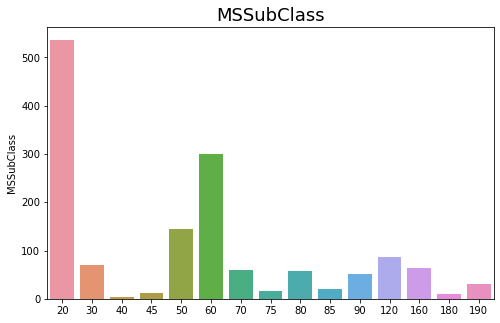

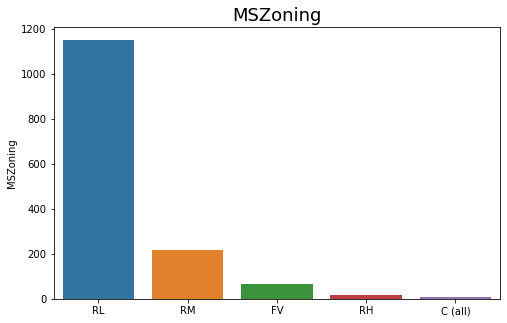

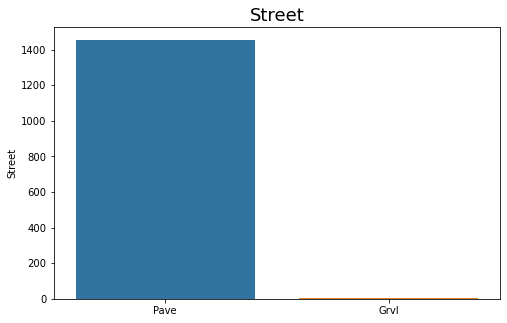

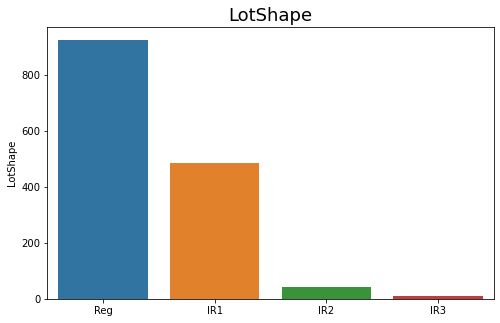

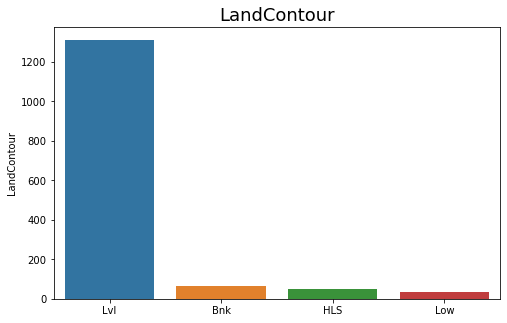

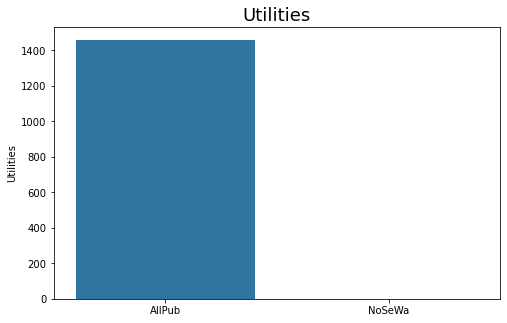

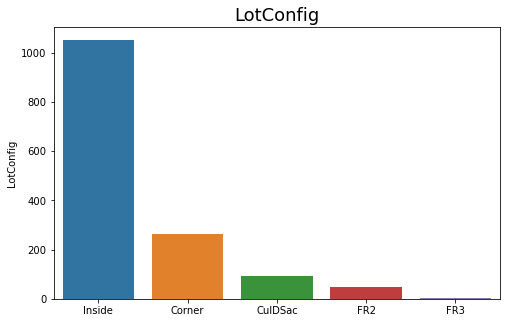

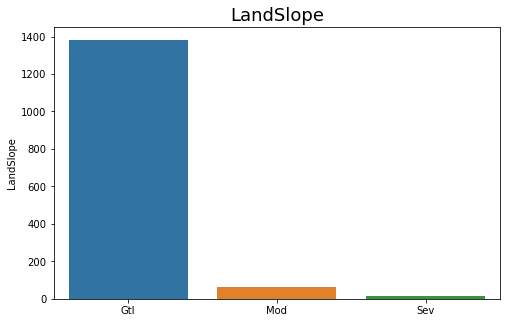

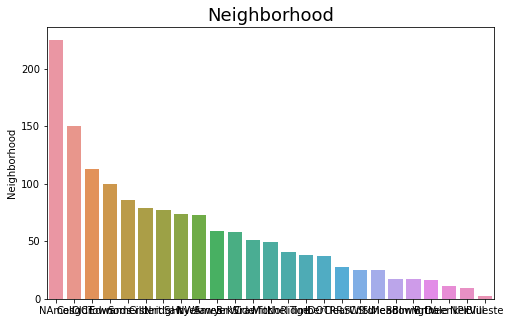

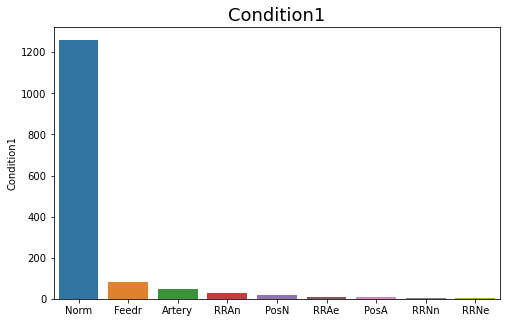

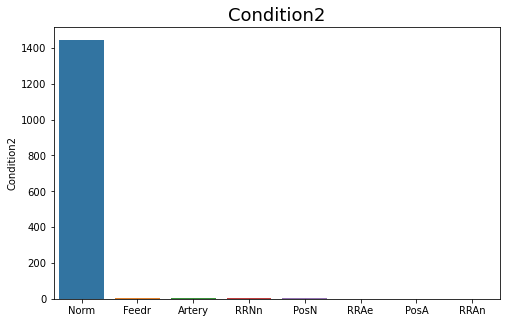

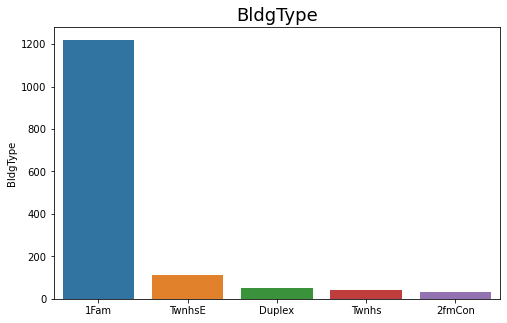

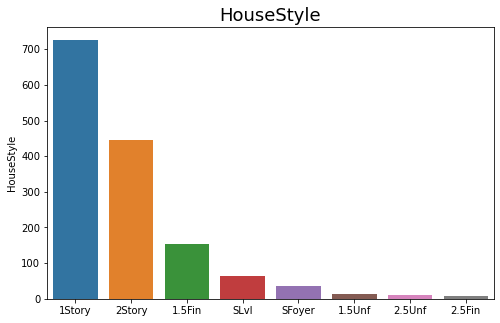

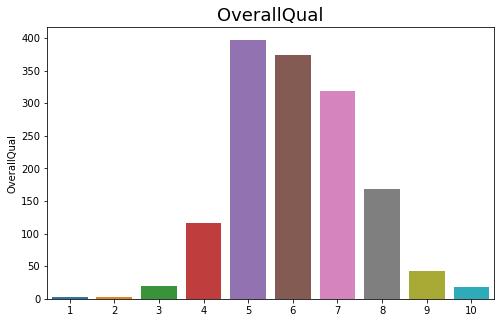

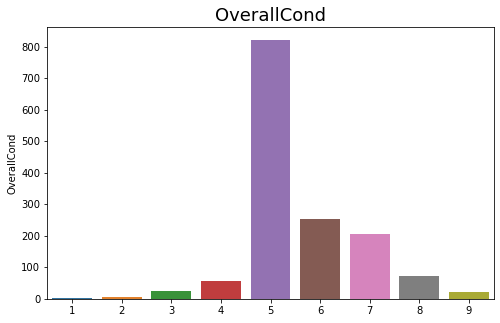

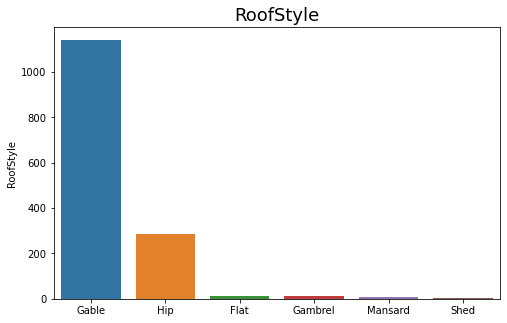

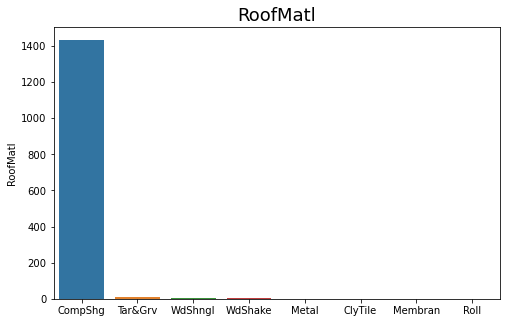

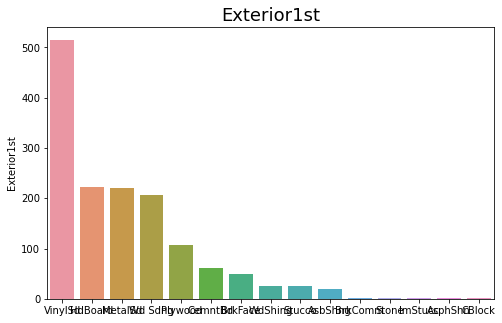

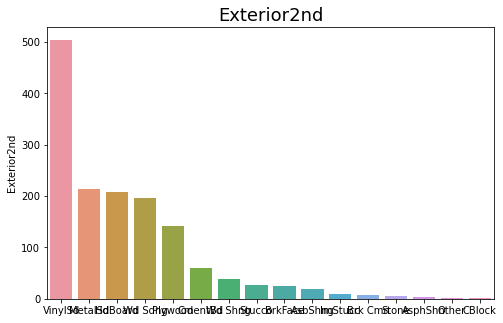

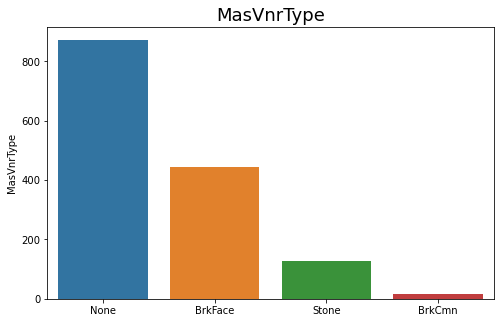

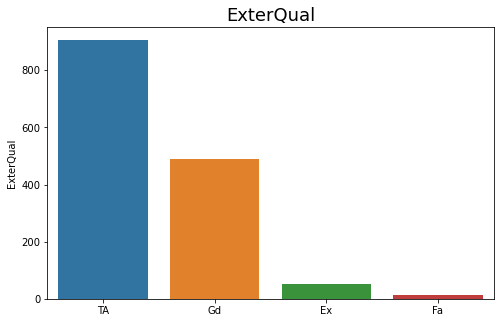

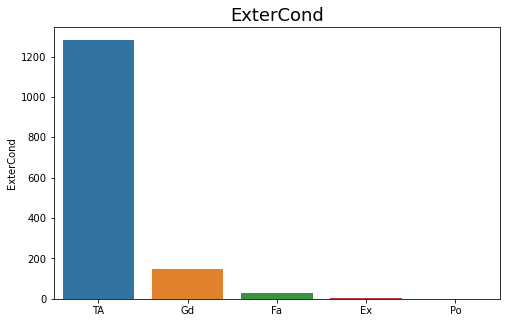

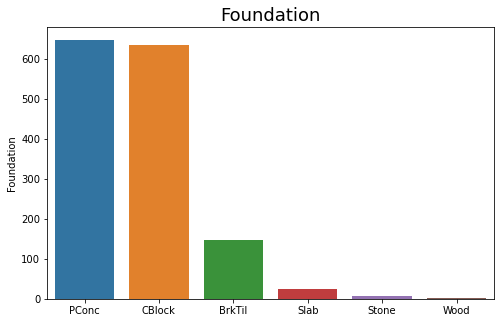

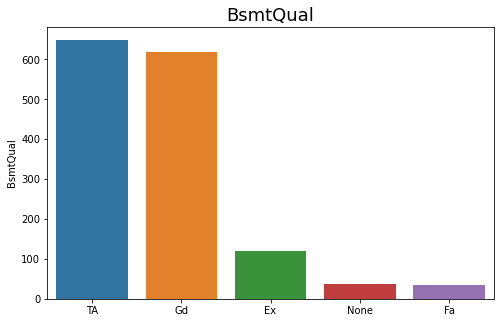

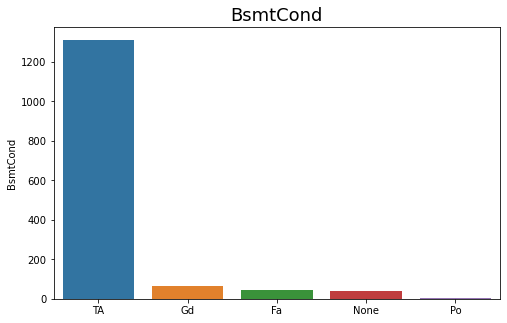

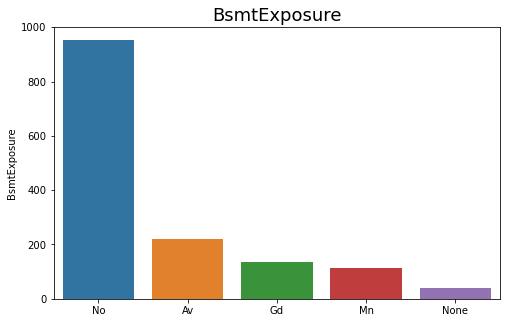

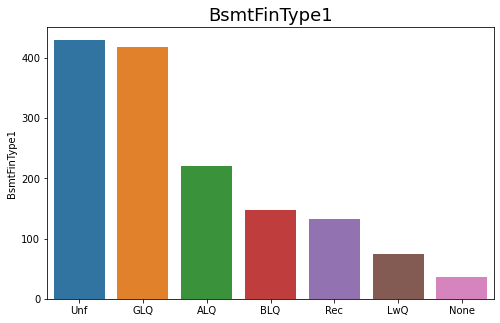

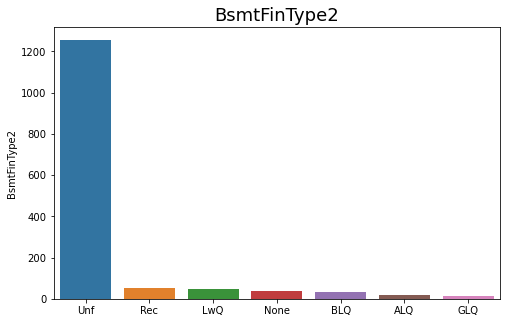

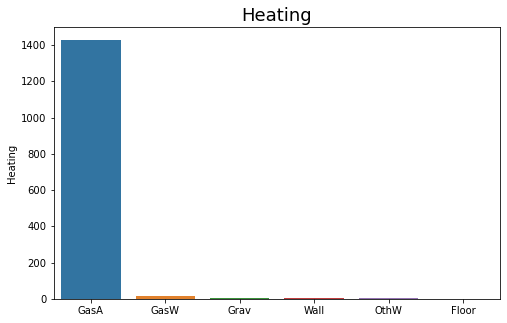

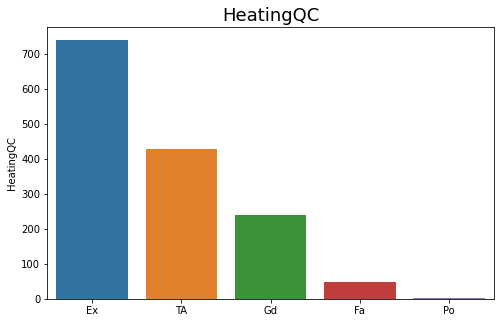

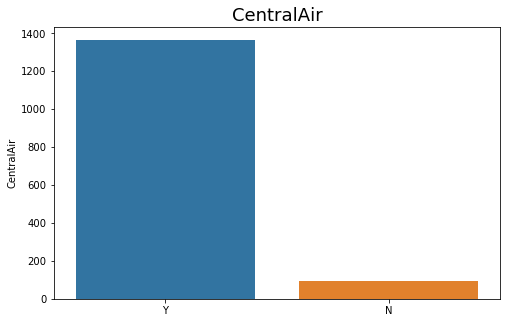

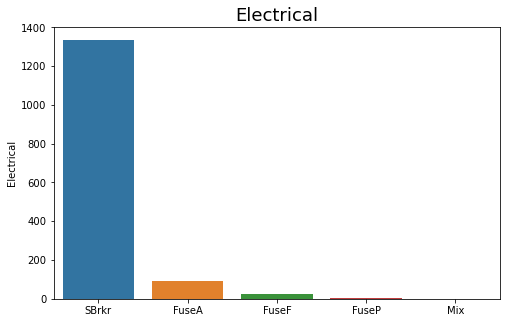

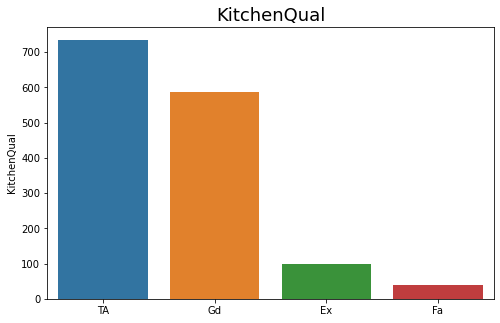

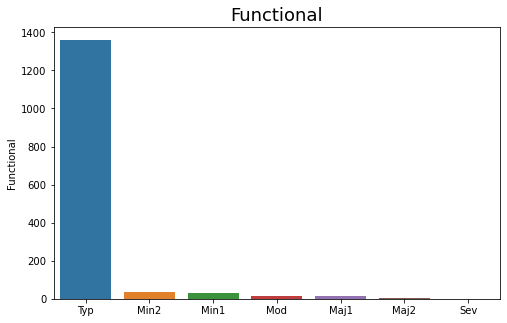

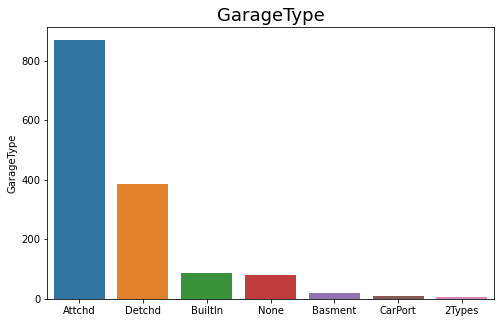

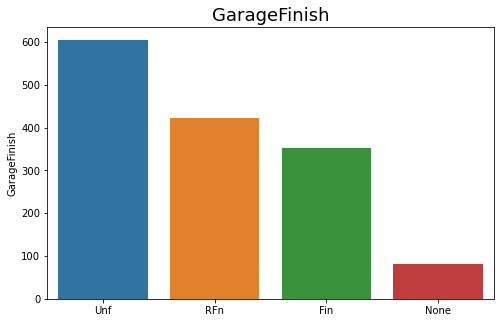

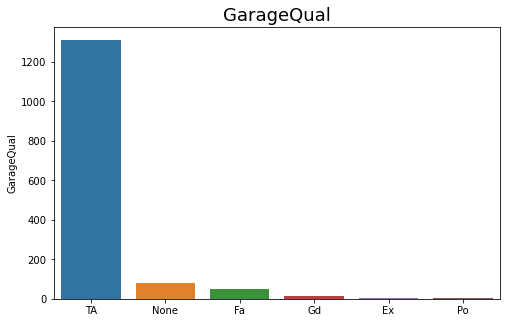

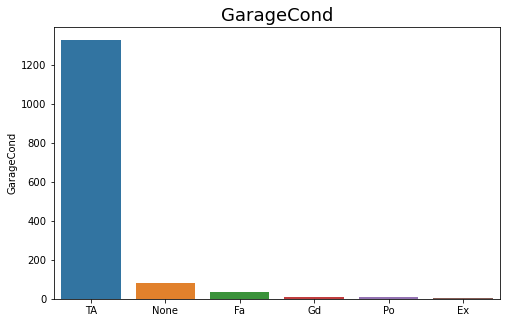

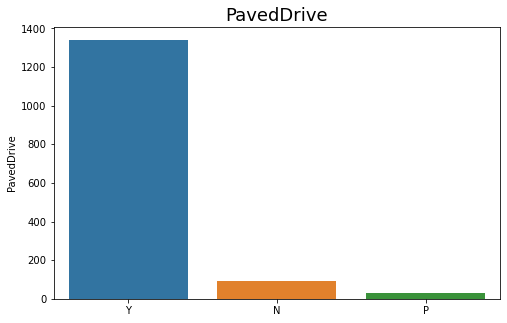

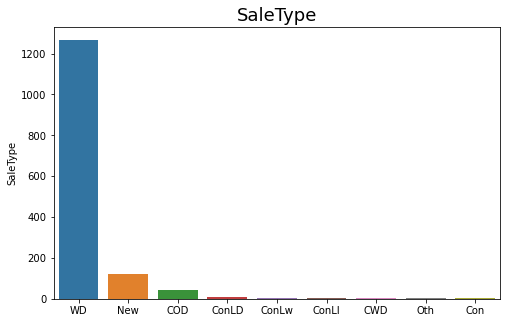

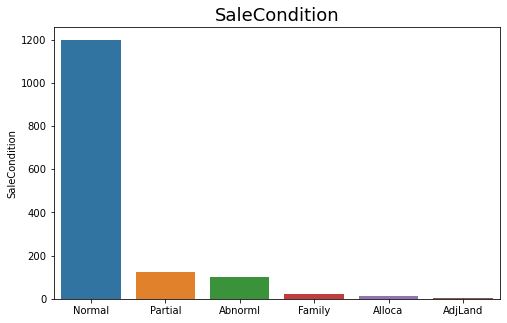

In [165]:
## Visualizing the levels of categorical columns using bar plots
for col in housing_df_cat.columns:
    plt.figure(figsize=(8,5))
    plt.title(col, fontdict={'fontsize': 18})
    sns.barplot(housing_df_cat[col].value_counts().index, housing_df_cat[col].value_counts())
    plt.show()

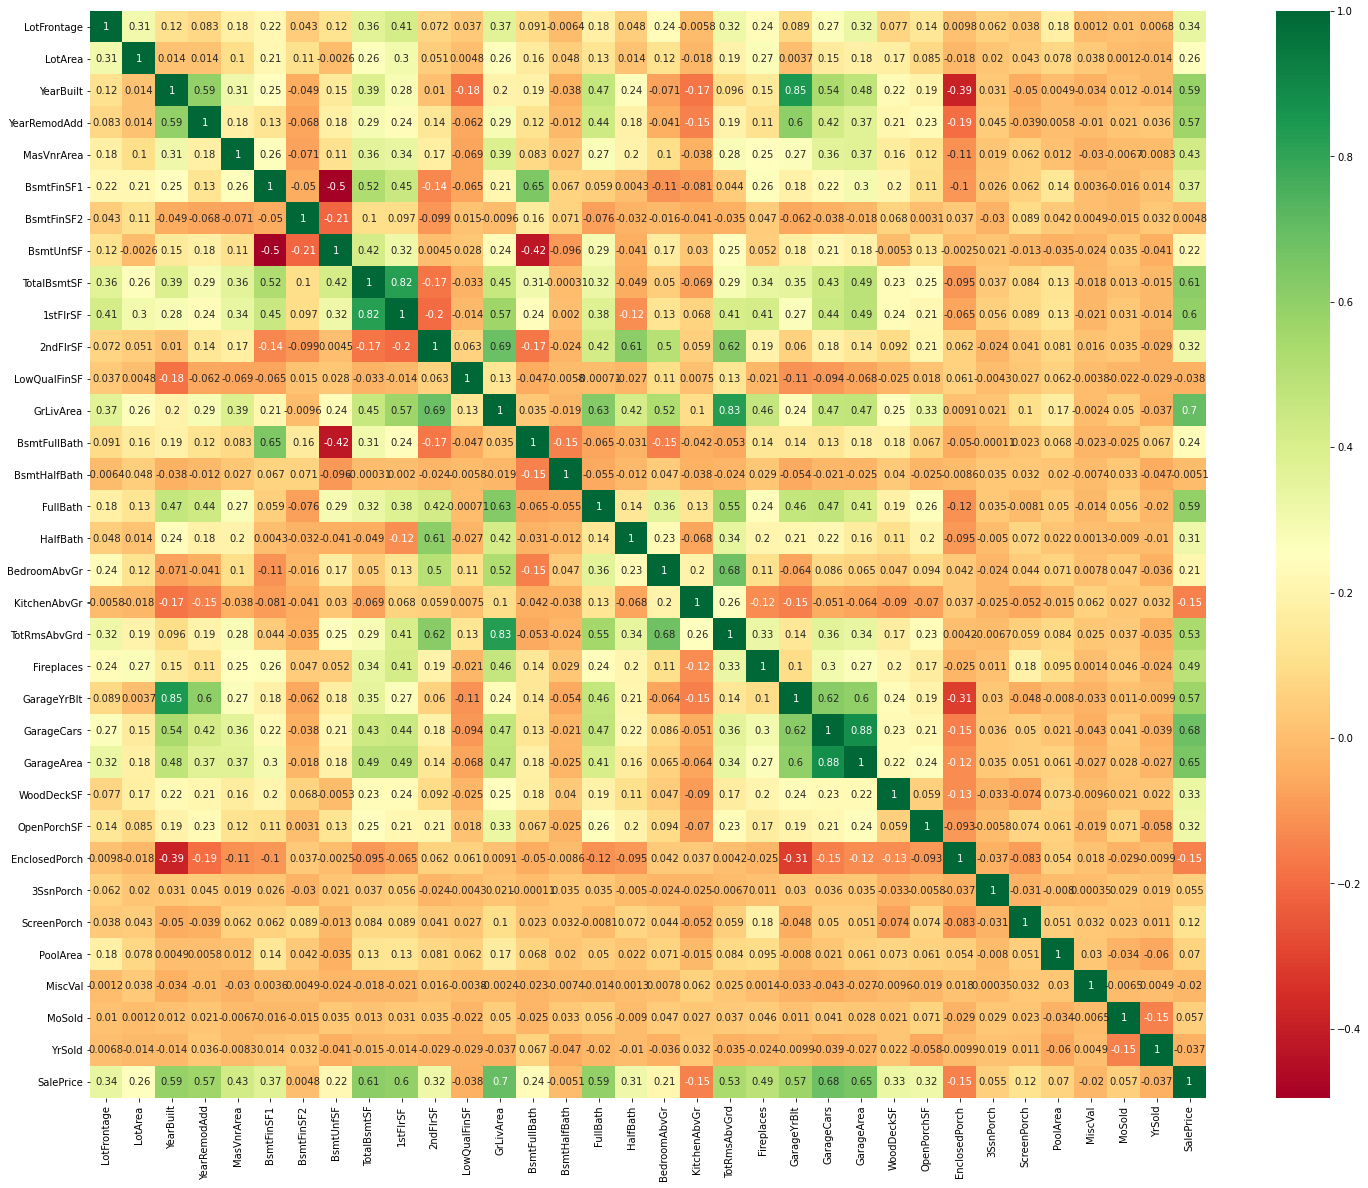

In [166]:
# Plot heatmap to detect correlations among numerical variables
plt.figure(figsize=(25,20))
sns.heatmap(housing_df_num.corr(), annot=True, cmap='RdYlGn');

# Observations:
# 1. Multicollinearity exists in the data 

## Data Processing

In [167]:
# One hot encoding

housing_df_cat_encoded = pd.get_dummies(housing_df_cat, drop_first=True)
housing_df_cat_encoded.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,

In [168]:
housing_df_cat_encoded.shape

(1460, 236)

### Outlier Treatment

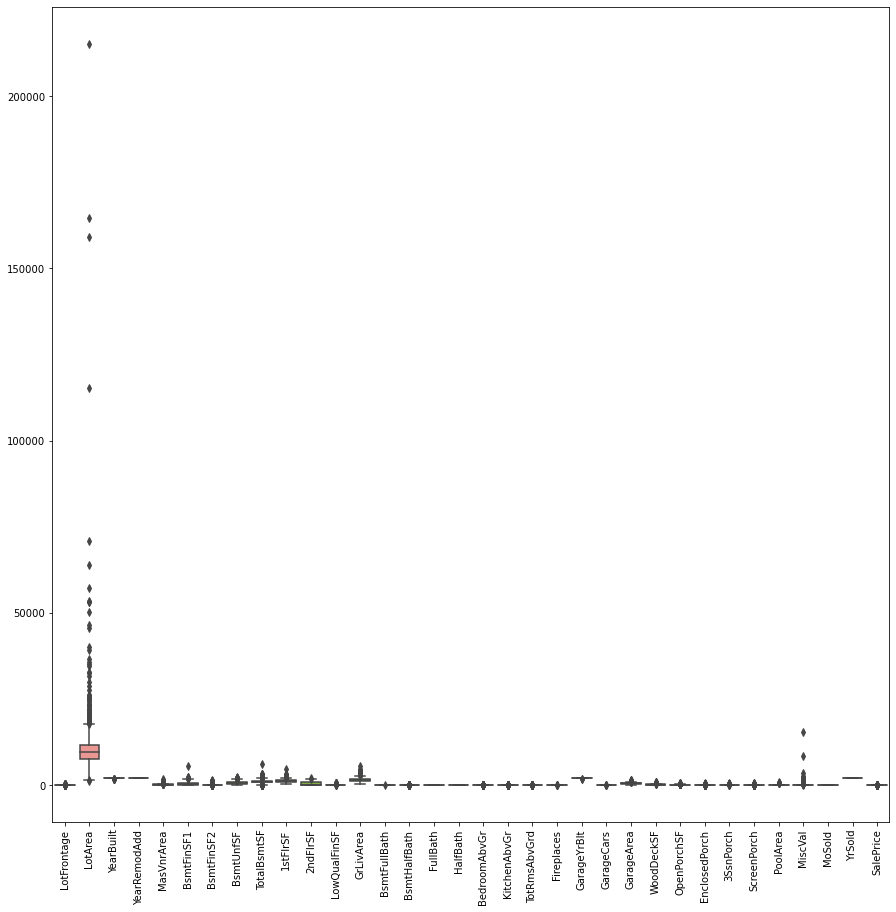

In [169]:
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=housing_df_num);

In [170]:
## Capping outliers to 5% at lower bound and 95% at upper bound
for col in housing_df_num.columns:
    housing_df_num[col][housing_df_num[col] <= housing_df_num[col].quantile(0.05)] = housing_df_num[col].quantile(0.05)
    housing_df_num[col][housing_df_num[col] >= housing_df_num[col].quantile(0.95)] = housing_df_num[col].quantile(0.95)

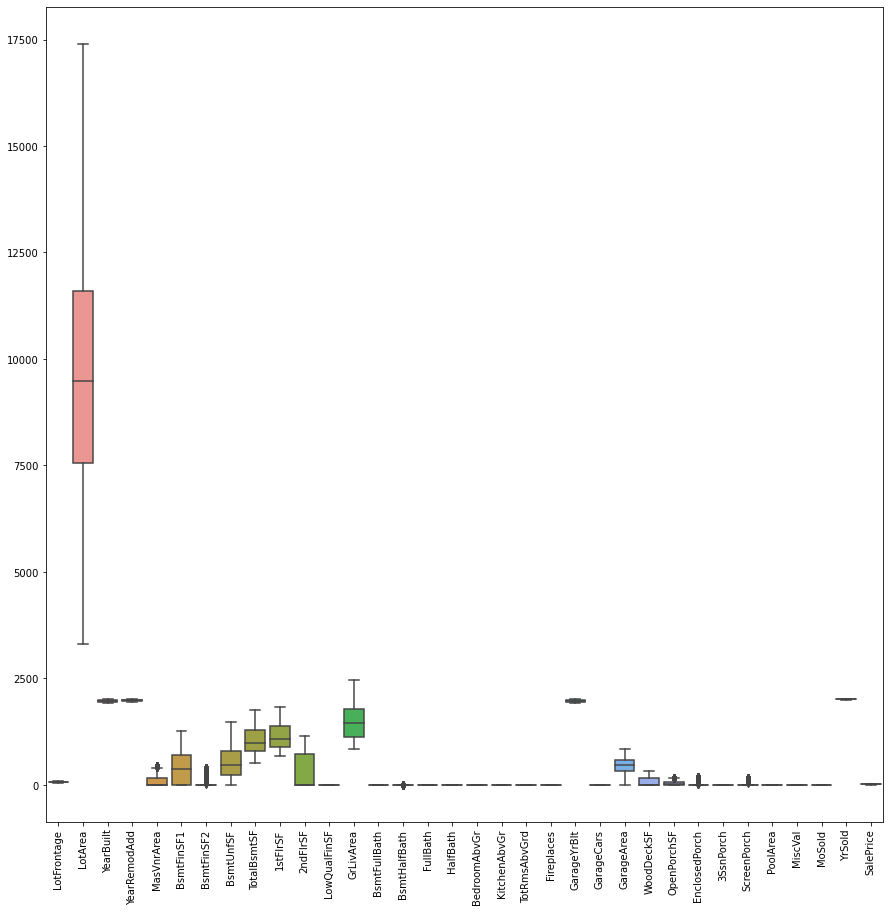

In [171]:
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=housing_df_num);

#Observations
# Looks like the outliers have been successfully removed

In [172]:
final_df = pd.concat([housing_df_num, housing_df_cat_encoded], axis=1)

final_df.head(5)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_

## Model Building

In [173]:
# Independent columns

X = final_df.drop(["SalePrice"], axis=1).copy()
X.head()



,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDri

In [174]:
# Target column

y = final_df["SalePrice"].copy()
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

### Train - Test Split

In [175]:
## Splitting X and y into 80% train data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90, shuffle=True)

In [176]:
## View dimensions of train data
print(X_train.shape)
print(y_train.shape)

(1168, 269)
(1168,)


In [177]:
## View dimensions of test data
print(X_test.shape)
print(y_test.shape)

(292, 269)
(292,)


In [178]:
## Create a list of numerical columns to be scaled
num_cols = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
num_cols

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [179]:
## Create a scaling instance
scaler = StandardScaler()

## Scale the numerical columns 
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### Ridge Regression

In [180]:
## Now to create a Ridge Regression model
## we will run a cross validation on a list of alphas to find the optimum value of alpha

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

ridge = Ridge()

# cross validation

ridgeCV = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
ridgeCV.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [181]:
ridgeCV.best_params_

{'alpha': 6.0}

In [182]:
## View the results of cross validation search
ridgeCV.cv_results_

{'mean_fit_time': array([0.13830037, 0.03615861, 0.04580922, 0.04247389, 0.05133519,
        0.04447808, 0.03864484, 0.03823814, 0.04397297, 0.02162066,
        0.02224679, 0.02086411, 0.03040004, 0.02294693, 0.02095232,
        0.0244009 , 0.02457862, 0.02724042, 0.02279458, 0.02264028,
        0.02348733, 0.02325354, 0.02137456, 0.0233284 , 0.02169247,
        0.02478766, 0.02847033, 0.02633419]),
 'std_fit_time': array([0.04709548, 0.00510685, 0.01448024, 0.01349057, 0.01213079,
        0.01269695, 0.00522729, 0.00979551, 0.01086119, 0.00324941,
        0.00263473, 0.00226499, 0.00827674, 0.00273649, 0.00183432,
        0.00259434, 0.00372018, 0.01020073, 0.00320094, 0.00569018,
        0.002932  , 0.00296371, 0.00160745, 0.00322851, 0.00287802,
        0.00264938, 0.00502493, 0.00186031]),
 'mean_score_time': array([0.01067567, 0.00883179, 0.01042142, 0.01323457, 0.00860462,
        0.01319189, 0.01262951, 0.01228843, 0.00745578, 0.00750318,
        0.00751238, 0.00639215, 0.006717

In [183]:
ridge = Ridge(alpha=6)

In [184]:
ridge.fit(X_train, y_train)

Ridge(alpha=6)

In [185]:
ridge.coef_

array([ 7.37060649e-03,  2.26511537e-02,  4.16356101e-02,  2.13863518e-02,
       -3.42379567e-03,  7.51381001e-03,  8.51713053e-04, -1.65276668e-02,
        4.80160256e-02,  1.54254929e-02,  3.92491581e-02,  0.00000000e+00,
        8.21847244e-02,  7.91113036e-03,  1.05305933e-03,  1.71009712e-02,
        1.00121802e-02,  1.77841777e-03,  0.00000000e+00, -1.71711730e-03,
        1.81619237e-02, -9.73829136e-03,  1.74656594e-02,  2.10290176e-02,
        1.32457787e-02,  1.00848609e-02,  3.07292283e-03,  0.00000000e+00,
        9.24236306e-03,  0.00000000e+00,  0.00000000e+00,  1.15635898e-03,
       -3.21542561e-03, -4.61629820e-02, -1.27267067e-02, -7.59566644e-03,
       -6.26929727e-03, -1.27256921e-03,  4.35563797e-02,  1.50612656e-02,
       -2.48106345e-03,  5.70238623e-03, -2.84922442e-02,  2.18038620e-03,
       -4.12839736e-02, -2.03621171e-02, -2.68753794e-02,  5.19700960e-02,
        1.77542308e-02,  2.32290822e-02, -1.09687414e-02,  2.69706335e-02,
        5.10530654e-03, -

In [186]:
## Make predictions
y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

In [187]:
## Check metrics
ridge_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.94
R-Squared (Test) = 0.91
RSS (Train) = 8.51
RSS (Test) = 3.22
MSE (Train) = 0.01
MSE (Test) = 0.01
RMSE (Train) = 0.09
RMSE (Test) = 0.11


In [188]:
## Create a dataframe of ridge cross validation results
ridgeCV_results= pd.DataFrame(ridgeCV.cv_results_)
ridgeCV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.138300,0.047095,0.010676,0.006457,0.0001,{'alpha': 0.0001},-0.088542,-0.077896,-0.082685,-0.079998,-0.077487,-0.081322,0.004054,25,-0.054887,-0.054695,-0.056178,-0.054965,-0.054023,-0.054950,0.000698
1,0.036159,0.005107,0.008832,0.001968,0.001,{'alpha': 0.001},-0.088401,-0.077852,-0.082545,-0.079964,-0.077444,-0.081241,0.004012,24,-0.054900,-0.054710,-0.056188,-0.054977,-0.054036,-0.054962,0.000697
2,0.045809,0.014480,0.010421,0.003216,0.01,{'alpha': 0.01},-0.087197,-0.077457,-0.081380,-0.079648,-0.077051,-0.080547,0.003674,23,-0.055040,-0.054857,-0.056277,-0.055096,-0.054179,-0.055090,0.000677
3,0.042474,0.013491,0.013235,0.006599,0.05,{'alpha': 0.05},-0.084063,-0.076317,-0.079086,-0.078775,-0.076232,-0.078895,0.002846,22,-0.055554,-0.055397,-0.056599,-0.055510,-0.054756,-0.055563,0.000593
4,0.051335,0.012131,0.008605,0.001586,0.1,{'alpha': 0.1},-0.082203,-0.075605,-0.078243,-0.078176,-0.075870,-0.078019,0.002368,20,-0.056026,-0.055830,-0.056839,-0.055880,-0.055201,-0.055955,0.000525
5,0.044478,0.012697,0.013192,0.003674,0.2,{'alpha': 0.2},-0.080476,-0.074864,-0.077464,-0.077464,-0.075364,-0.077126,0.001984,19,-0.056577,-0.056400,-0.057130,-0.056349,-0.055763,-0.056444,0.000439
6,0.038645,0.005227,0.012630,0.004013,0.3,{'alpha': 0.3},-0.079598,-0.074841,-0.077001,-0.077007,-0.074974,-0.076684,0.001733,18,-0.056930,-0.056762,-0.057341,-0.056638,-0.056136,-0.056761,0.000392
7,0.038238,0.009796,0.012288,0.004449,0.4,{'alpha': 0.4},-0.079014,-0.074775,-0.076672,-0.076672,-0.074693,-0.076365,0.001583,17,-0.057184,-0.057082,-0.057507,-0.056862,-0.056406,-0.057008,0.000366
8,0.043973,0.010861,0.007456,0.001280,0.5,{'alpha': 0.5},-0.078596,-0.074717,-0.076476,-0.076397,-0.074445,-0.076126,0.001491,16,-0.057401,-0.057338,-0.057654,-0.057046,-0.056621,-0.057212,0.000353
9,0.021621,0.003249,0.007503,0.001429,0.6,{'alpha': 0.6},-0.078249,-0.074667,-0.076339,-0.076163,-0.074244,-0.075932,0.001417,15,-0.057590,-0.057547,-0.057784,-0.057206,-0.056821,-0.057390,0.000340


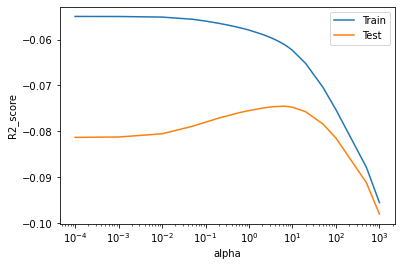

In [189]:
## Plotting R2 score vs alpha values
plt.plot(ridgeCV_results['param_alpha'], ridgeCV_results['mean_train_score'], label='Train')
plt.plot(ridgeCV_results['param_alpha'], ridgeCV_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

### Lasso

In [190]:
params = {'alpha': [ 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

lasso = Lasso()

# cross validation

lassoCV = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
lassoCV.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [191]:
lassoCV.best_params_

{'alpha': 0.001}

In [192]:
lassoCV.cv_results_

{'mean_fit_time': array([0.07085476, 0.03998084, 0.02879372, 0.02294607, 0.01996741,
        0.0154501 , 0.01542706, 0.01687746, 0.01929193, 0.01696396,
        0.01755428, 0.01760907, 0.01737442, 0.01625137, 0.01965237,
        0.01894417, 0.01882882, 0.01537018, 0.01581707, 0.01686106,
        0.01779575, 0.02073851, 0.02597914, 0.03937058, 0.0270474 ,
        0.11655464, 0.07083173]),
 'std_fit_time': array([0.01395514, 0.01414903, 0.00403938, 0.00430217, 0.00176688,
        0.00058793, 0.00088544, 0.00142995, 0.00176345, 0.00064474,
        0.00219153, 0.00304654, 0.00179417, 0.0011041 , 0.00330694,
        0.00150492, 0.00322623, 0.00090225, 0.00175643, 0.00237664,
        0.00148584, 0.00743168, 0.00763327, 0.02017472, 0.00917255,
        0.15255763, 0.06555506]),
 'mean_score_time': array([0.01352587, 0.01118598, 0.00723209, 0.00753808, 0.00840993,
        0.00703812, 0.00987601, 0.00722198, 0.00850534, 0.00744429,
        0.00695696, 0.00820289, 0.00728221, 0.00872917, 0.009379

In [193]:
lasso = Lasso(alpha=0.001)

In [194]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.001)

In [195]:
lasso.coef_

array([ 0.00597253,  0.02160739,  0.04251708,  0.0308982 , -0.        ,
        0.02492229,  0.00343265, -0.        ,  0.04721063,  0.        ,
        0.02602645,  0.        ,  0.10148268,  0.00849721,  0.00152111,
        0.00810072,  0.00638634, -0.        ,  0.        , -0.        ,
        0.0226551 , -0.        ,  0.02174957,  0.01914592,  0.01282112,
        0.01034188,  0.0010772 ,  0.        ,  0.00934682,  0.        ,
        0.        ,  0.00088007, -0.00237675, -0.01263573, -0.        ,
        0.        ,  0.        , -0.        ,  0.02926468,  0.        ,
        0.        ,  0.        , -0.01739872,  0.        , -0.01869359,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.03380192,  0.        ,  0.        , -0.        , -0.00818183,
        0.        ,  0.        , -0.        ,  0.        ,  0.01317519,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.01848507,  0.01286685, -0.  

In [196]:
## Make predictions
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

In [197]:
## Check metrics
lasso_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.92
R-Squared (Test) = 0.91
RSS (Train) = 11.01
RSS (Test) = 3.44
MSE (Train) = 0.01
MSE (Test) = 0.01
RMSE (Train) = 0.10
RMSE (Test) = 0.11


In [198]:
## Create a dataframe of ridge cross validation results
lassoCV_results= pd.DataFrame(lassoCV.cv_results_)
lassoCV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.070855,0.013955,0.013526,0.007935,0.001,{'alpha': 0.001},-0.075436,-0.076084,-0.081745,-0.071389,-0.078274,-0.076585,0.003408,1,-0.070008,-0.068537,-0.068344,-0.069230,-0.068236,-0.068871,0.000665
1,0.039981,0.014149,0.011186,0.004360,0.01,{'alpha': 0.01},-0.096685,-0.101409,-0.100009,-0.091335,-0.096707,-0.097229,0.003479,2,-0.095486,-0.094325,-0.093950,-0.095892,-0.095632,-0.095057,0.000771
2,0.028794,0.004039,0.007232,0.000450,0.05,{'alpha': 0.05},-0.119326,-0.127913,-0.119997,-0.111875,-0.118711,-0.119565,0.005095,3,-0.118900,-0.116757,-0.117550,-0.120025,-0.119279,-0.118502,0.001186
3,0.022946,0.004302,0.007538,0.000658,0.1,{'alpha': 0.1},-0.160809,-0.165838,-0.155743,-0.153122,-0.155658,-0.158234,0.004548,4,-0.157561,-0.155228,-0.157499,-0.158749,-0.156939,-0.157195,0.001147
4,0.019967,0.001767,0.008410,0.002737,0.2,{'alpha': 0.2},-0.252967,-0.252143,-0.246552,-0.249805,-0.237727,-0.247839,0.005525,5,-0.246912,-0.243786,-0.248188,-0.250981,-0.244959,-0.246965,0.002520
5,0.015450,0.000588,0.007038,0.000201,0.3,{'alpha': 0.3},-0.293846,-0.291934,-0.287802,-0.291789,-0.277925,-0.288659,0.005716,6,-0.286866,-0.287441,-0.288897,-0.287929,-0.290823,-0.288391,0.001387
6,0.015427,0.000885,0.009876,0.002378,0.4,{'alpha': 0.4},-0.293846,-0.291934,-0.287802,-0.291789,-0.277925,-0.288659,0.005716,6,-0.286866,-0.287441,-0.288897,-0.287929,-0.290823,-0.288391,0.001387
7,0.016877,0.001430,0.007222,0.000662,0.5,{'alpha': 0.5},-0.293846,-0.291934,-0.287802,-0.291789,-0.277925,-0.288659,0.005716,6,-0.286866,-0.287441,-0.288897,-0.287929,-0.290823,-0.288391,0.001387
8,0.019292,0.001763,0.008505,0.001254,0.6,{'alpha': 0.6},-0.293846,-0.291934,-0.287802,-0.291789,-0.277925,-0.288659,0.005716,6,-0.286866,-0.287441,-0.288897,-0.287929,-0.290823,-0.288391,0.001387
9,0.016964,0.000645,0.007444,0.001163,0.7,{'alpha': 0.7},-0.293846,-0.291934,-0.287802,-0.291789,-0.277925,-0.288659,0.005716,6,-0.286866,-0.287441,-0.288897,-0.287929,-0.290823,-0.288391,0.001387


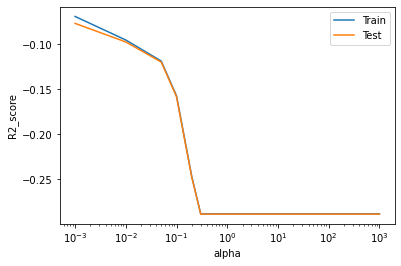

In [199]:
## Plotting R2 score vs alpha values
plt.plot(lassoCV_results['param_alpha'], lassoCV_results['mean_train_score'], label='Train')
plt.plot(lassoCV_results['param_alpha'], lassoCV_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

## Model Comparison

In [200]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)', 'RMSE (Train)', 'RMSE (Test)'],
            'Ridge Regression' : ridge_metrics,
            'Lasso Regression' : lasso_metrics
        }

final_metric = pd.DataFrame(lr_table, columns = ['Metric', 'Ridge Regression', 'Lasso Regression'] )
final_metric.set_index('Metric')

,Ridge Regression,Lasso Regression
Metric,,
R2 Score (Train),0.940745,0.923320
R2 Score (Test),0.914588,0.908910
RSS (Train),8.511096,11.014013
RSS (Test),3.222556,3.436802
MSE (Train),0.007287,0.009430
MSE (Test),0.011036,0.011770
RMSE (Train),0.085363,0.097107
RMSE (Test),0.105053,0.108489


In [201]:
## Now we see the changes in coefficients after regularization

## First create empty datafame with all the independent variables as indices
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas

""
LotFrontage
LotArea
YearBuilt
YearRemodAdd
MasVnrArea
...
SaleCondition_AdjLand
SaleCondition_Alloca
SaleCondition_Family
SaleCondition_Normal


In [202]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [203]:
betas

,Ridge,Lasso
LotFrontage,0.007371,0.005973
LotArea,0.022651,0.021607
YearBuilt,0.041636,0.042517
YearRemodAdd,0.021386,0.030898
MasVnrArea,-0.003424,-0.000000
...,...,...
SaleCondition_AdjLand,0.030226,0.000000
SaleCondition_Alloca,0.067912,0.000000
SaleCondition_Family,-0.029094,-0.000000
SaleCondition_Normal,0.046084,0.031329


In [204]:
## View the features removed by Lasso
betas[betas['Lasso']==0]

,Ridge,Lasso
MasVnrArea,-0.003424,-0.0
BsmtUnfSF,-0.016528,-0.0
1stFlrSF,0.015425,0.0
LowQualFinSF,0.000000,0.0
BedroomAbvGr,0.001778,-0.0
...,...,...
SaleType_Oth,0.016022,0.0
SaleType_WD,0.003286,-0.0
SaleCondition_AdjLand,0.030226,0.0
SaleCondition_Alloca,0.067912,0.0


In [205]:
## View the number of features removed by lasso
betas[betas['Lasso']==0].shape

(189, 2)

In [206]:
## View the features selected by lasso
betas.loc[betas['Lasso']!=0, 'Lasso']

LotFrontage              0.005973
LotArea                  0.021607
YearBuilt                0.042517
YearRemodAdd             0.030898
BsmtFinSF1               0.024922
BsmtFinSF2               0.003433
TotalBsmtSF              0.047211
2ndFlrSF                 0.026026
GrLivArea                0.101483
BsmtFullBath             0.008497
BsmtHalfBath             0.001521
FullBath                 0.008101
HalfBath                 0.006386
Fireplaces               0.022655
GarageCars               0.021750
GarageArea               0.019146
WoodDeckSF               0.012821
OpenPorchSF              0.010342
EnclosedPorch            0.001077
ScreenPorch              0.009347
MoSold                   0.000880
YrSold                  -0.002377
MSSubClass_30           -0.012636
MSSubClass_70            0.029265
MSSubClass_90           -0.017399
MSSubClass_160          -0.018694
MSZoning_RM             -0.033802
LotShape_Reg            -0.008182
LotConfig_CulDSac        0.013175
Neighborhood_B

## Inference

In [207]:
betas['Ridge'].sort_values(ascending=False)[:5]

GrLivArea               0.082185
Neighborhood_Crawfor    0.081253
OverallCond_9           0.080227
OverallQual_9           0.079334
OverallQual_8           0.078797
Name: Ridge, dtype: float64

In [208]:
ridge_coeffs = np.exp(betas['Ridge'])
ridge_coeffs.sort_values(ascending=False)[:5]

GrLivArea               1.085656
Neighborhood_Crawfor    1.084645
OverallCond_9           1.083534
OverallQual_9           1.082566
OverallQual_8           1.081985
Name: Ridge, dtype: float64

In [209]:
betas['Lasso'].sort_values(ascending=False)[:5]

OverallQual_9           0.107508
GrLivArea               0.101483
OverallQual_8           0.096252
Neighborhood_Crawfor    0.089216
Functional_Typ          0.066701
Name: Lasso, dtype: float64

In [210]:
## To interpret the lasso coefficients in terms of target, we have to take inverse log (i.e. 10 to the power) of betas
lasso_coeffs = np.exp(betas['Lasso'])
lasso_coeffs.sort_values(ascending=False)[:5]

OverallQual_9           1.113500
GrLivArea               1.106811
OverallQual_8           1.101037
Neighborhood_Crawfor    1.093317
Functional_Typ          1.068976
Name: Lasso, dtype: float64

## **Both the models have given similar test R2 - around 0.91**

### **Top Features Selected by Ridge Model are**:

_GrLivArea              
Neighborhood_Crawfor    
OverallCond_9           
OverallQual_9           
OverallQual_8_

### **Top Features Selected by Lasso Model are**:

_OverallQual_9           
GrLivArea               
OverallQual_8           
Neighborhood_Crawfor    
Functional_Typ_         

### Four out of top 5 features are common between both the models and by using Lasso we also eliminated a lot of features - Hence we can go with Lasso for this problem statement

## Subjective Questions

### Question 1

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

In [211]:
ridge = Ridge(alpha=6)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)
ridge_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.94
R-Squared (Test) = 0.91
RSS (Train) = 8.51
RSS (Test) = 3.22
MSE (Train) = 0.01
MSE (Test) = 0.01
RMSE (Train) = 0.09
RMSE (Test) = 0.11


In [212]:
ridge = Ridge(alpha=12)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)
ridge_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.94
R-Squared (Test) = 0.91
RSS (Train) = 9.01
RSS (Test) = 3.27
MSE (Train) = 0.01
MSE (Test) = 0.01
RMSE (Train) = 0.09
RMSE (Test) = 0.11


In [213]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
lasso_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.92
R-Squared (Test) = 0.91
RSS (Train) = 11.01
RSS (Test) = 3.44
MSE (Train) = 0.01
MSE (Test) = 0.01
RMSE (Train) = 0.10
RMSE (Test) = 0.11


In [214]:
lasso = Lasso(alpha=0.002)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
lasso_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.91
R-Squared (Test) = 0.89
RSS (Train) = 13.31
RSS (Test) = 4.06
MSE (Train) = 0.01
MSE (Test) = 0.01
RMSE (Train) = 0.11
RMSE (Test) = 0.12


In [215]:
## First create empty datafame with all the independent variables as indices
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas

betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_



In [216]:
betas['Ridge'].sort_values(ascending=False)[:5]

GrLivArea               0.077578
OverallQual_8           0.073078
Neighborhood_Crawfor    0.072631
OverallQual_9           0.067093
Functional_Typ          0.066299
Name: Ridge, dtype: float64

In [217]:
betas['Lasso'].sort_values(ascending=False)[:5]

GrLivArea               0.107567
OverallQual_8           0.078526
Neighborhood_Crawfor    0.068482
Functional_Typ          0.064581
OverallQual_9           0.054726
Name: Lasso, dtype: float64

### Question 2

You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

**Ridge Regression:**
- Ridge Regression adds the squared magnitude of coefficients as a penalty term to the loss function.
- It can shrink coefficients towards zero, but they never reach exactly zero.
- It is useful when you suspect that many features contribute to the outcome, and you want to control multicollinearity (high correlation between features).
- Ridge can provide a more stable solution when dealing with a dataset with a high number of correlated features.

**Lasso Regression:**
- Lasso Regression adds the absolute value of coefficients as a penalty term to the loss function.
- It can shrink coefficients all the way to zero, effectively performing feature selection.
- It is suitable when you believe that only a subset of features is relevant to the outcome.
- Lasso can help you identify the most important features in your model.

**Choosing Between Them:**
- If you have a strong reason to believe that only a few features are relevant, and you want a model that can eliminate less important features, Lasso Regression might be preferred.
- If you suspect multicollinearity among features and want to control their impact without necessarily removing them, Ridge Regression could be a better choice.

I will apply Lasso Regression as the R2 between Lasso and Ridge on test data is almost same and Lasso also helped in eliminating less important features

### Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [218]:
top5_features = ['GrLivArea','OverallQual_8','Neighborhood_Crawfor','Functional_Typ','OverallQual_9']

X_train_dropped = X_train.drop(top5_features, axis=1)
X_test_dropped = X_test.drop(top5_features, axis=1)

params = {'alpha': [ 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

lasso = Lasso()

# cross validation

lassoCV = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
lassoCV.fit(X_train_dropped, y_train) 

lassoCV.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'alpha': 0.001}

In [219]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_dropped, y_train)
y_train_pred = lasso.predict(X_train_dropped)
y_pred = lasso.predict(X_test_dropped)
lasso_metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)

R-Squared (Train) = 0.92
R-Squared (Test) = 0.90
RSS (Train) = 12.17
RSS (Test) = 3.87
MSE (Train) = 0.01
MSE (Test) = 0.01
RMSE (Train) = 0.10
RMSE (Test) = 0.12


In [220]:
betas = pd.DataFrame(index=X_train_dropped.columns)
betas.rows = X_train_dropped.columns
betas

betas['Lasso'] = lasso.coef_

betas['Lasso'].sort_values(ascending=False)[:5]

2ndFlrSF               0.101949
Exterior1st_BrkFace    0.059058
1stFlrSF               0.057802
TotalBsmtSF            0.055075
MSSubClass_70          0.051334
Name: Lasso, dtype: float64

### Question 4

How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?

**Steps to Make a Model Robust and Generalizable:**

1. **Train-Test Split:** Split your dataset into training and testing sets. This allows you to train the model on one subset and evaluate its performance on an unseen subset.

2. **Cross-Validation:** Implement techniques like k-fold cross-validation to validate the model's performance across different subsets of the data. This helps assess how well the model generalizes to new data.

3. **Feature Engineering:** Select relevant features and preprocess them appropriately. Avoid overfitting by not using too many features, which can lead to poor generalization.

4. **Regularization:** Apply regularization techniques like Ridge or Lasso Regression to control overfitting and improve generalization.

5. **Hyperparameter Tuning:** Optimize hyperparameters through methods like grid search or random search to find the best settings for your model.

6. **Outlier Handling:** Identify and handle outliers in the data, which can significantly impact model performance.

7. **Ensemble Methods:** Consider using ensemble techniques like Random Forest or Gradient Boosting, which combine multiple models to improve robustness.

**Implications for Model Accuracy:**

1. **Overfitting:** A model that performs well on training data but poorly on test data is likely overfitting. Overfitting leads to high accuracy on known data but poor performance on new data. Ensuring robustness helps mitigate overfitting.

2. **Bias-Variance Trade-off:** A model with high variance can capture noise in the training data and may not generalize well. A balanced model, achieved through robustness, has lower variance and better generalization.

3. **Accuracy and Generalization:** A model's accuracy on training data doesn't necessarily guarantee its accuracy on new data. A model's generalization ability, assessed through test data or cross-validation, is a better indicator of real-world performance.

4. **Reduced Model Complexity:** A more robust model often has a simplified structure, reducing complexity and making it less prone to capturing noise in the data.

In essence, making a model robust and generalizable involves finding a balance between fitting the training data well and ensuring that the model's performance extends to unseen data. While a model's accuracy on training data might be high, its true test comes from how well it performs on new, real-world data. Prioritizing generalization is essential for a model's reliability in practical applications.